In [1]:
import json

from pyproj import CRS, Transformer
from specklepy.api.client import SpeckleClient
from specklepy.core.api import operations
from specklepy.transports.server import ServerTransport

# Leapfrog Weka Hills Demo Model from Speckle to IFC 5

In [2]:
weka_hills_speckle_project_id = "7a489ac0d4"
ifc5_tunnel_dict = {
    "alignment": {"ifc5_ref": "N2152bb32e4a045a1ba475c39b312e069"},
    "excavation": {"ifc5_ref": "N59ec758cbae14f2fb4e1c0240a1f79d8"},
}

In [3]:
speckle_client = SpeckleClient(host="app.speckle.systems")
transport = ServerTransport(
    stream_id=weka_hills_speckle_project_id, client=speckle_client
)

c:\Users\joost\ReposWindows\IFC5-development\.venv\Lib\site-packages\specklepy\transports\server\server.py:73: SpeckleWarning: Unauthenticated Speckle Client provided to Server Transport for https://app.speckle.systems. Receiving from private streams will fail.
  warn(


In [4]:
transport

In [5]:
weka_hills_speckle_models = speckle_client.model.get_models(
    project_id=weka_hills_speckle_project_id
)

for model in weka_hills_speckle_models.items:
    if "tunnel" in model.name:
        tunnel_model = str(model.name).replace("tunnel/", "")
        print(f"{tunnel_model}: {model.id}")
        if tunnel_model not in ifc5_tunnel_dict.keys():
            continue

        speckle_model = speckle_client.model.get_with_versions(
            model_id=model.id,
            project_id=weka_hills_speckle_project_id,
        )
        ifc5_tunnel_dict[tunnel_model]["speckle_model"] = speckle_model

excavation: 9069ef2b2b
lining: 6bd2a019cb
alignment: 643ad7861d


In [6]:
ifc5_tunnel_dict[tunnel_model]["speckle_model"].versions.items[0].referencedObject

'e185acb83934eb6b4554a86fb4362951'

In [7]:
ifc5_tunnel_dict.keys()

dict_keys(['alignment', 'excavation'])

In [8]:
model_data = operations.receive(
    ifc5_tunnel_dict["alignment"]["speckle_model"].versions.items[0].referencedObject,
    transport,
)

ValueError: not enough values to unpack (expected 2, got 1)

In [9]:
excavation_model_data = operations.receive(
    ifc5_tunnel_dict["excavation"]["speckle_model"].versions.items[0].referencedObject,
    remote_transport=transport,
)

ValueError: not enough values to unpack (expected 2, got 1)

Version(authorUser=LimitedUser(id='88153cc720', name='Joost Gevaert', bio='', company='Bedrock', avatar='', verified=True, role='server:user'), createdAt=datetime.datetime(2025, 1, 27, 20, 31, 9, 910000, tzinfo=TzInfo(UTC)), id='542a48d337', message=None, previewUrl='https://app.speckle.systems/preview/7a489ac0d4/commits/542a48d337', referencedObject='78f8b3ca58a87a77d752c6ef1a65a81a', sourceApplication='rhino')
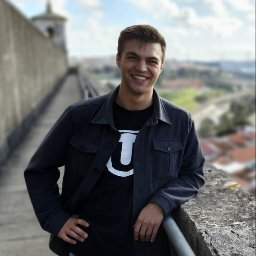

In [11]:
ifc5_tunnel_dict["excavation"]["speckle_model"].versions.items[0]

In [32]:
ifc5_tunnel_dict["excavation"]["speckle_model"].versions.items[0].referencedObject

'78f8b3ca58a87a77d752c6ef1a65a81a'

In [25]:
for key, value in ifc5_tunnel_dict.items():
    model_data = operations.receive(
        ifc5_tunnel_dict[key]["speckle_model"].versions.items[0].referencedObject,
        transport,
    )

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
speckle_faces = model_data.elements[0].elements[0].elements[0].elements[0].faces
face_vertex_counts = []
face_vertex_indices = []
i = 0
while i < len(speckle_faces):
    vertex_count = speckle_faces[i]
    face_vertex_counts.append(vertex_count)
    face_vertex_indices.extend(speckle_faces[i + 1 : i + 1 + vertex_count])
    i += 1 + vertex_count

speckle_vertices = model_data.elements[0].elements[0].elements[0].elements[0].vertices
points = [speckle_vertices[i : i + 3] for i in range(0, len(speckle_vertices), 3)]

In [ ]:
= =-th open(
    f"WekaHills_GeologyModel_{ifc5_geo_dict['name']}_UsdGeom.ifcx", "w"
) as json_file:
    json.dump(ifc5_usdgeom, json_file)

For testing purposes, one can create an `.obj` file from the Speckle geometry as follows:

In [ ]:
with open(f"{tunnel_model}Mesh.obj", "w") as obj_file:
    for point in points:
        obj_file.write(f"v {point[0]} {point[1]} {point[2]}\n")
    for i in range(0, len(face_vertex_indices), 3):
        # OBJ uses 1-based indexing, so add 1 to the indices
        obj_file.write(
            f"f {face_vertex_indices[i] + 1} {face_vertex_indices[i + 1] + 1} {face_vertex_indices[i + 2] + 1}\n"
        )

# CRS Objects in IFC 5

Coordinate Reference Systems (CRS') can be defined using the Well-Known Text representation of Coordinate Reference Systems (WKT-CRS | [Wikipedia](http://en.wikipedia.org/wiki/Well-known_text_representation_of_coordinate_reference_systems) | [OGC Specification](https://docs.ogc.org/is/18-010r7/18-010r7.html)). This representation of CRS' is also an ISO standard: ISO 19162:2019.

Notes from the Wikipedia WKT-CRS "Version history" section:

>  Confusingly, the original 2015 "WKT 2" standard has a version number 1 for the new, stricter WKT-CRS specification. A newer revision called WKT-CRS 2 was published in 2018, with the ISO version being ISO 19162:2019.

> ESRI vs OGC  
> ... some databases differentiate between "OGC WKT" and "ESRI WKT" representations. The problem is largely resolved in WKT[-CRS] 2, as it is better-defined.

These differences in how WKT strings are also clear from the export section when looking up a CRS on [epsg.io](https://epsg.io). For example, have a look at the differences between the "OGC WKT", "OGC WKT 2" and "ESRI WKT" results in the export section at the bottom of the [epsg.io/2193](https://epsg.io/2193) page.

In [4]:
weka_hills_crs = CRS(2193)

In [ ]:
ifc5_wkt_crs = [
    {
        "def": "def",
        "name": "CRS_EPSG:2193",
        "type": "OGC:CRS",
        "attributes": {
            "WKT-CRS": {
                "ISO": "ISO 19162:2019",
                "wkt": weka_hills_crs.to_wkt(),
                "name": weka_hills_crs.name,
                "authority_id": f"EPSG:{weka_hills_crs.to_authority()[1]}",
                "units": "m",
                "offset_x": 0,
                "offset_y": 0,
                "offset_z": 0,
                "rotation": 0,
            }
        },
    },
    {
        "def": "over",
        "name": "Nad68cd145a6b43fdb0232e0b11a6c7bc",
        "comment": "Assigns CRS_EPSG:2193 to the instance of borehole WH_009",
        "attributes": {"crs": {"ref": "</CRS_EPSG:2193>"}},
    },
    {
        "def": "over",
        "name": "N996ff9e7b86240f898d4d038ab311d1b",
        "comment": "Assigns CRS_EPSG:2193 to the instance of borehole WH_012",
        "attributes": {"crs": {"ref": "</CRS_EPSG:2193>"}},
    },
    {
        "def": "over",
        "name": "N25dbbae886194be6b469e4f17f0b605c",
        "comment": "Assigns CRS_EPSG:2193 to the instance of the GeologyModel",
        "attributes": {"crs": {"ref": "</CRS_EPSG:2193>"}},
    },
]

with open("WekaHills_CRS_EPSG2193.ifcx", "w") as json_file:
    json.dump(ifc5_wkt_crs, json_file, indent=2)

Longitude is the x-coordinate or east-west coordinate on earth expressed in 0 to 180 degrees east or west of the Greenwich prime meridian or in -180 to 180 degrees relative to the Greenwich prime meridian.

Latitude is the y-coordinate or north-south coordinate on earth expressed in 0 to 90 north or south of the equator or in -90 to 90 degrees relative to the equator.

Historically, coordinates on earth are denoted (Latitude, Longitude), because it was easier to determine the north-south position than the east-west position. This because the north-south position can be determined from the sun, stars and other heavenly bodies, whereas one need to accurately know the time in order to determine the east-west position.

Nowadays, especially on the web, it's common to write coordinates on earth in [Longitude, Latitude], because we commonly write down coordinates [x, y].

In [10]:
transformer = Transformer.from_crs(weka_hills_crs, 4326, always_xy=True)
custom_lon, custom_lat = transformer.transform(1166250.104, 4888836.859)
custom_crs_wkt = f'PROJCS["SpeckleCRS_latlon_{custom_lat}_{custom_lon}", GEOGCS["GCS_WGS_1984", DATUM["D_WGS_1984", SPHEROID["WGS_1984", 6378137.0, 298.257223563]], PRIMEM["Greenwich", 0.0], UNIT["Degree", 0.0174532925199433]], PROJECTION["Transverse_Mercator"], PARAMETER["False_Easting", 0.0], PARAMETER["False_Northing", 0.0], PARAMETER["Central_Meridian", {custom_lon}], PARAMETER["Scale_Factor", 1.0], PARAMETER["Latitude_Of_Origin", {custom_lat}], UNIT["Meter", 1.0]]'